<a href="https://colab.research.google.com/github/noamgafni/STA160Project/blob/main/STA160_logreg_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Replace with your actual filename
df = pd.read_csv('/content/val_data.csv')  # or .read_parquet() if it's parquet

print("Filename: val_data.csv")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

FileNotFoundError: [Errno 2] No such file or directory: '/content/val_data.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    accuracy_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("="*60)
print("LOADING DATA")
print("="*60)

train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

print(f"\nTrain: {train.shape}")
print(f"Val:   {val.shape}")
print(f"Test:  {test.shape}")

LOADING DATA

Train: (108087, 49)
Val:   (69993, 49)
Test:  (83035, 49)


In [ ]:
print("\n" + "="*60)
print("CREATING DIRECTION TARGET (UP=1, DOWN=0)")
print("="*60)

# Binary direction: 1 if next day return > 0, else 0
train['Direction'] = (train['Next_Day_Return'] > 0).astype(int)
val['Direction'] = (val['Next_Day_Return'] > 0).astype(int)
test['Direction'] = (test['Next_Day_Return'] > 0).astype(int)

print(f"\nTrain Direction Distribution:")
print(train['Direction'].value_counts(normalize=True))
print(f"\nVal Direction Distribution:")
print(val['Direction'].value_counts(normalize=True))
print(f"\nTest Direction Distribution:")
print(test['Direction'].value_counts(normalize=True))


CREATING DIRECTION TARGET (UP=1, DOWN=0)

Train Direction Distribution:
Direction
0    0.505352
1    0.494648
Name: proportion, dtype: float64

Val Direction Distribution:
Direction
0    0.513937
1    0.486063
Name: proportion, dtype: float64

Test Direction Distribution:
Direction
0    0.515229
1    0.484771
Name: proportion, dtype: float64


In [ ]:
print("\n" + "="*60)
print("SELECTING FEATURES")
print("="*60)

# Exclude non-predictive columns
exclude_cols = [
    'Date', 'Coin', 'Name',  # Identifiers
    'Next_Day_Return',        # This is what we're predicting
    'Tail_Risk_Event',        # Alternative target
    'Direction'               # Our new target
]

# Get all numeric feature columns
feature_cols = [col for col in train.columns if col not in exclude_cols]

print(f"\nTotal features: {len(feature_cols)}")
print(f"\nFeature categories:")
print(f"  - Price/Volume: Open, High, Low, Close, Volume")
print(f"  - Returns: Returns, Returns_Lag_*")
print(f"  - Volatility: Vol_5d, Vol_10d, Vol_20d, Vol_30d")
print(f"  - Technical: SMA_*, RSI, MACD, BB_*, ATR_*")
print(f"  - Volume features: Volume_Lag_*, Vol_Change, Vol_Ratio_*")


SELECTING FEATURES

Total features: 44

Feature categories:
  - Price/Volume: Open, High, Low, Close, Volume
  - Returns: Returns, Returns_Lag_*
  - Volatility: Vol_5d, Vol_10d, Vol_20d, Vol_30d
  - Technical: SMA_*, RSI, MACD, BB_*, ATR_*
  - Volume features: Volume_Lag_*, Vol_Change, Vol_Ratio_*


In [ ]:
###redundant

print("\n" + "="*60)
print("PREPARING DATA")
print("="*60)

# Extract features and target
X_train = train[feature_cols].copy()
y_train = train['Direction'].copy()

X_val = val[feature_cols].copy()
y_val = val['Direction'].copy()

X_test = test[feature_cols].copy()
y_test = test['Direction'].copy()

print(f"\nMissing values before cleaning:")
print(f"  Train: {X_train.isnull().sum().sum()}")
print(f"  Val:   {X_val.isnull().sum().sum()}")
print(f"  Test:  {X_test.isnull().sum().sum()}")

# Drop rows with any missing values
train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
val_mask = ~(X_val.isnull().any(axis=1) | y_val.isnull())
test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())

X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_val = X_val[val_mask]
y_val = y_val[val_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

print(f"\nAfter removing missing values:")
print(f"  Train: {X_train.shape[0]:,} samples")
print(f"  Val:   {X_val.shape[0]:,} samples")
print(f"  Test:  {X_test.shape[0]:,} samples")


PREPARING DATA

Missing values before cleaning:
  Train: 0
  Val:   0
  Test:  0

After removing missing values:
  Train: 108,087 samples
  Val:   69,993 samples
  Test:  83,035 samples


In [ ]:
print("\n" + "="*60)
print("STANDARDIZING FEATURES")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features standardized (mean=0, std=1)")
print(f"  Example feature before: mean={X_train.iloc[:, 0].mean():.3f}, std={X_train.iloc[:, 0].std():.3f}")
print(f"  Example feature after:  mean={X_train_scaled[:, 0].mean():.3f}, std={X_train_scaled[:, 0].std():.3f}")



STANDARDIZING FEATURES

✓ Features standardized (mean=0, std=1)
  Example feature before: mean=898.468, std=5438.785
  Example feature after:  mean=0.000, std=1.000


In [ ]:
print("\n" + "="*60)
print("TRAINING LOGISTIC REGRESSION")
print("="*60)

# Train model with class balancing
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle imbalanced classes
    random_state=42,
    solver='lbfgs',
    C=1.0  # Regularization strength (1/lambda)
)

print("\nModel parameters:")
print(f"  - Regularization: L2 (Ridge)")
print(f"  - Class weighting: Balanced")
print(f"  - Max iterations: 1000")
print(f"  - Solver: lbfgs")

model.fit(X_train_scaled, y_train)
print("\n✓ Model trained successfully!")


TRAINING LOGISTIC REGRESSION

Model parameters:
  - Regularization: L2 (Ridge)
  - Class weighting: Balanced
  - Max iterations: 1000
  - Solver: lbfgs

✓ Model trained successfully!


In [ ]:
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

# Get predictions and probabilities
y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = model.predict(X_val_scaled)
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\n✓ Predictions generated")


MAKING PREDICTIONS

✓ Predictions generated


print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

def print_metrics(y_true, y_pred, y_proba, dataset_name):
    print(f"\n{dataset_name} Set:")
    print("-" * 40)
    
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    print(f"\n  Classification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=['Down (0)', 'Up (1)'],
                                digits=4))
    
    return acc, auc, f1

train_metrics = print_metrics(y_train, y_train_pred, y_train_proba, "TRAIN")
val_metrics = print_metrics(y_val, y_val_pred, y_val_proba, "VALIDATION")
test_metrics = print_metrics(y_test, y_test_pred, y_test_proba, "TEST")



CONFUSION MATRICES


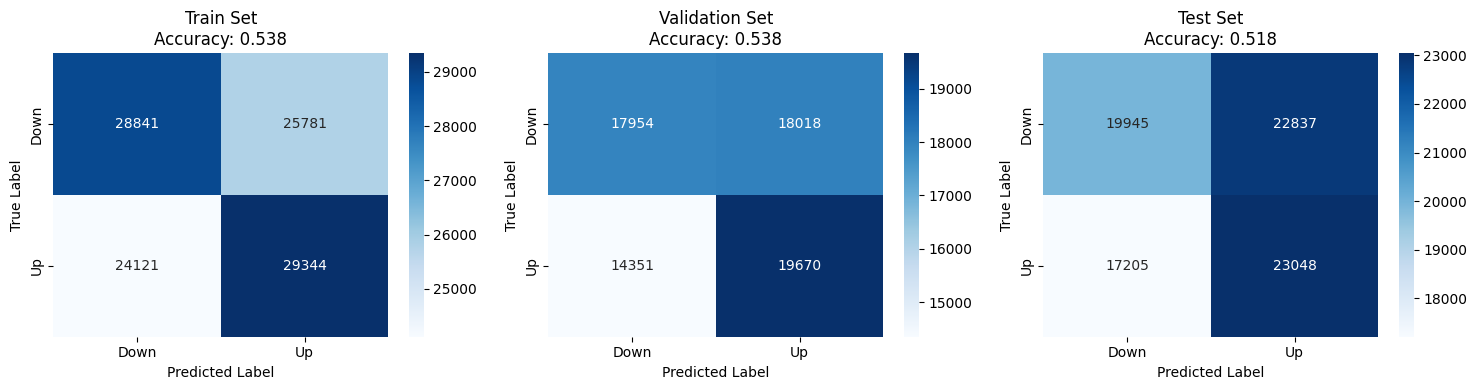

In [ ]:
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    (y_train, y_train_pred, 'Train'),
    (y_val, y_val_pred, 'Validation'),
    (y_test, y_test_pred, 'Test')
]

for ax, (y_true, y_pred, name) in zip(axes, datasets):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'])
    ax.set_title(f'{name} Set\nAccuracy: {accuracy_score(y_true, y_pred):.3f}')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


ROC CURVES


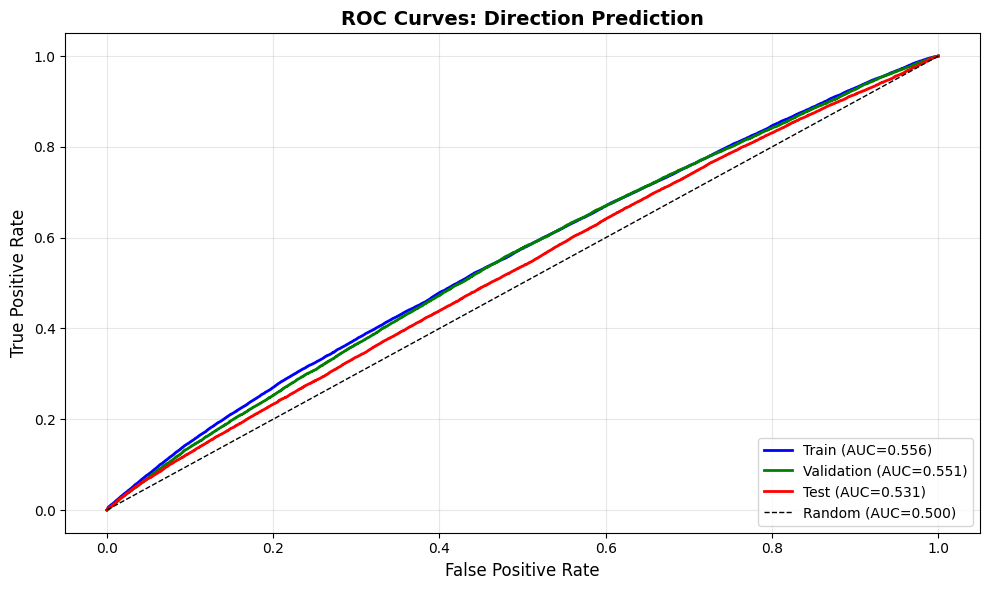

In [ ]:
print("\n" + "="*60)
print("ROC CURVES")
print("="*60)

plt.figure(figsize=(10, 6))

for y_true, y_proba, name, color in [
    (y_train, y_train_proba, 'Train', 'blue'),
    (y_val, y_val_proba, 'Validation', 'green'),
    (y_test, y_test_proba, 'Test', 'red')
]:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Direction Prediction', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 20)")
print("="*60)

# Get coefficients (positive = predicts UP, negative = predicts DOWN)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0]
})

# Sort by absolute value
feature_importance['Abs_Coef'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coef', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20)[['Feature', 'Coefficient']].to_string(index=False))

# Visualize top 20
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20).sort


FEATURE IMPORTANCE (Top 20)

Top 20 Most Important Features:
        Feature  Coefficient
    BB_Position    -0.188037
         RSI_14     0.141409
        Returns    -0.141205
       BB_Lower    -0.099079
       BB_Upper     0.078614
   Volume_Lag_2     0.056366
         Volume    -0.054738
        Vol_30d    -0.054633
Price_to_SMA_20    -0.054489
   Volume_Lag_1    -0.039760
     Vol_Change    -0.036046
   Vol_Ratio_5d     0.035239
Price_to_SMA_50     0.032514
   Volume_Lag_5    -0.029146
   Volume_Lag_3     0.027646
  Returns_Lag_3     0.022806
  Vol_Ratio_10d    -0.022213
          Close     0.019857
  Returns_Lag_2     0.018606
  Returns_Lag_7    -0.017170


AttributeError: 'DataFrame' object has no attribute 'sort'

<Figure size 1000x800 with 0 Axes>

LOADING DATA

Train: (108087, 49)
Val:   (69993, 49)
Test:  (83035, 49)

CREATING DIRECTION TARGET (UP=1, DOWN=0)

Class distribution:
Train UP%: 49.46%
Val UP%:   48.61%
Test UP%:  48.48%

USING ALL ORIGINAL FEATURES

Total features: 44

Feature groups:
  • OHLCV: Open, High, Low, Close, Volume
  • Returns: Returns, Returns_Lag_*
  • Volatility: Vol_5d, Vol_10d, Vol_20d, Vol_30d
  • Moving Averages: SMA_*, Price_to_SMA_*
  • Technical: RSI, MACD, ROC, BB, ATR
  • Volume: Volume_Lag_*, Vol_Ratio_*, Vol_Change

PREPARING DATA

Missing values before cleaning:
  Train: 0
  Val:   0
  Test:  0

After removing missing values:
  Train: 108,087 samples, 44 features
  Val:   69,993 samples
  Test:  83,035 samples

ROBUST FEATURE SCALING

✓ Features scaled using RobustScaler (median & IQR)
  More robust to outliers than StandardScaler

GRID SEARCH: OPTIMIZING FOR ROC-AUC

Testing configurations...
------------------------------------------------------------
lbfgs  | l2 | C= 0.001 -> AUC: 0.5470

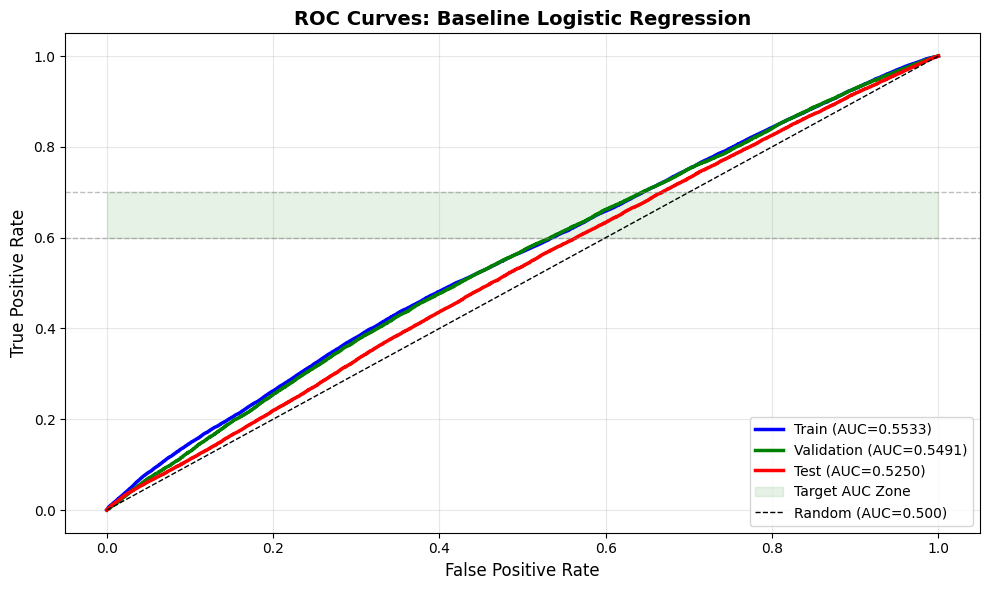


CONFUSION MATRICES


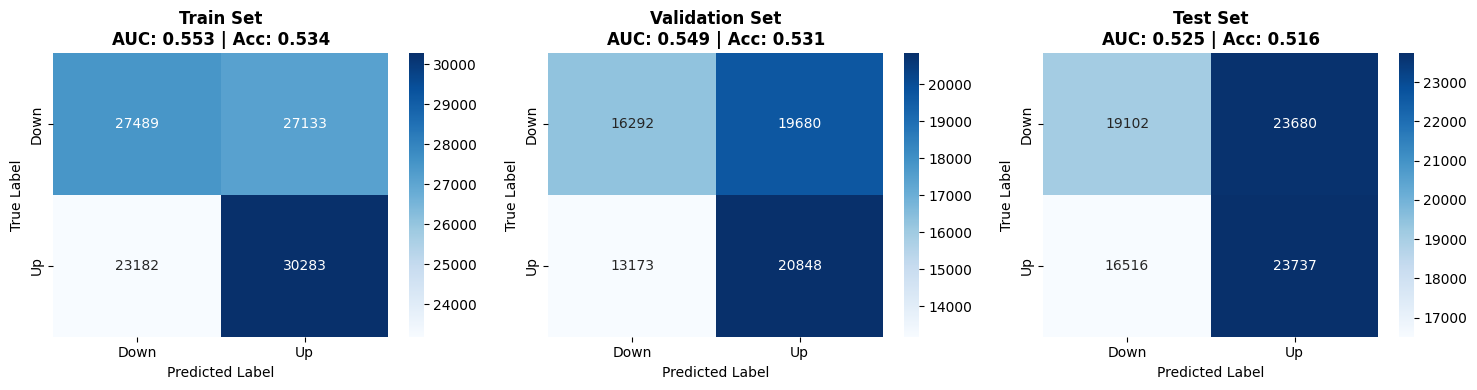


FEATURE IMPORTANCE (Top 20)

Top 20 Most Important Features:
        Feature  Coefficient
        Returns    -0.094188
    BB_Position    -0.040505
  Returns_Lag_1    -0.025440
Price_to_SMA_20    -0.021156
        Vol_30d    -0.017047
   Vol_Ratio_5d     0.011583
        Vol_20d    -0.009726
Price_to_SMA_50     0.009178
  Returns_Lag_3     0.007428
  Vol_Ratio_20d     0.006810
  Returns_Lag_5     0.006523
  Returns_Lag_7    -0.006433
         Vol_5d     0.005339
         RSI_14     0.004554
           Open     0.004161
         ROC_10     0.002832
          SMA_5     0.002714
       High_Low     0.002506
         ROC_20     0.002502
       BB_Lower    -0.002134


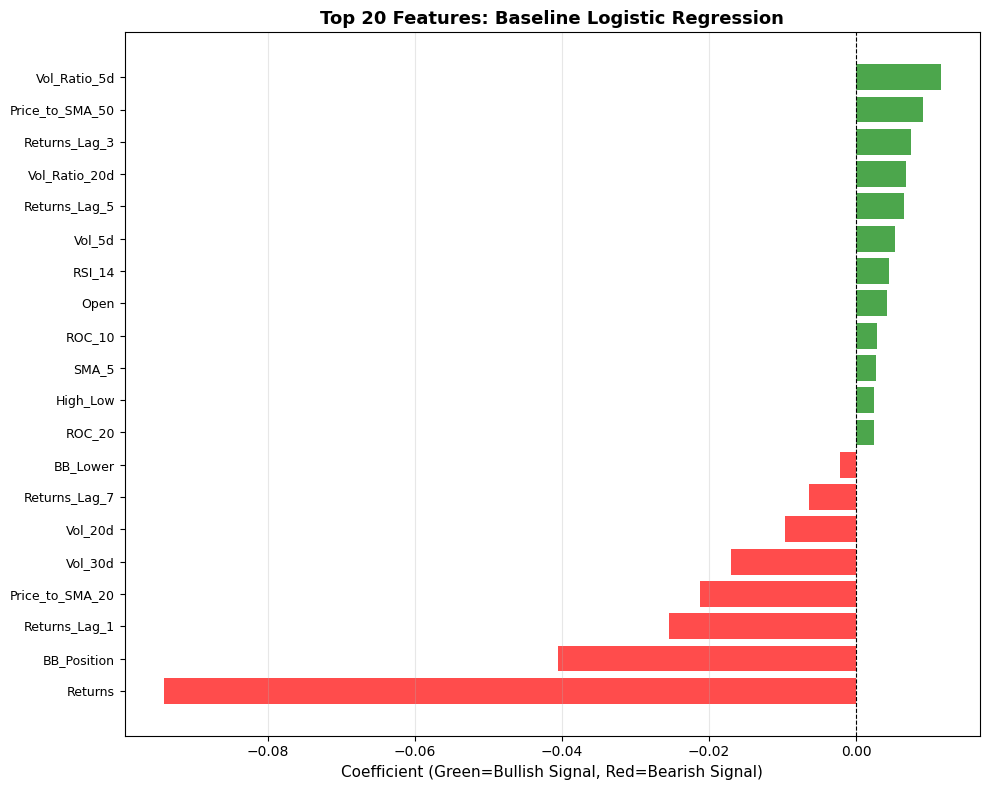


PREDICTION PROBABILITY DISTRIBUTION


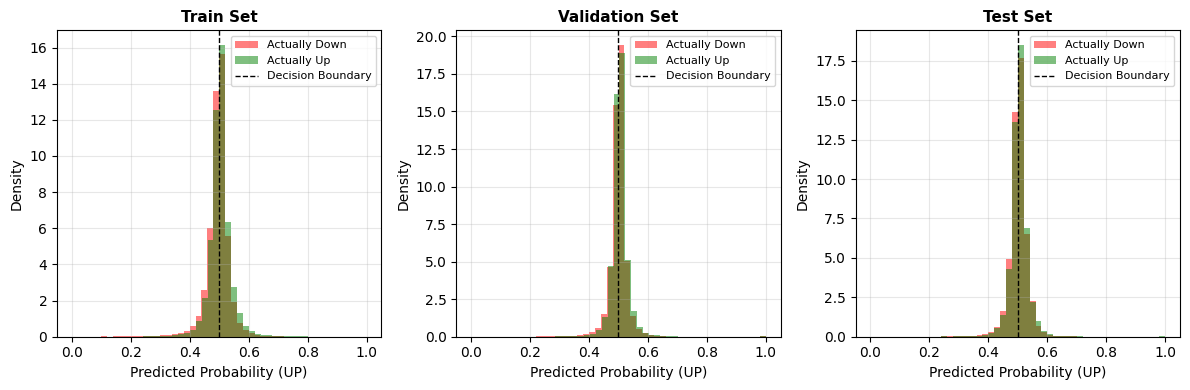


BASELINE MODEL SUMMARY

📊 Model Configuration:
   • Solver: lbfgs
   • Penalty: l2
   • C: 5.0
   • Features: 44 (all original)
   • Class weighting: Balanced

🎯 Performance:
   • Test ROC-AUC: 0.5250
   • Test Accuracy: 0.5159
   • Test F1-Score: 0.5415

💡 Interpretation:
   • AUC 0.5250 < 0.6 target
   • Suggests: Need better features or non-linear model
   • Still valid baseline to measure improvement against

BASELINE MODEL COMPLETE!


In [ ]:
# ============================================
# LOGISTIC REGRESSION V1: BASELINE MODEL
# Goal: Maximize ROC-AUC (0.6-0.7) with ALL features
# Accuracy ~55% is acceptable for baseline
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score,
    f1_score, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. LOAD DATA
# ============================================
print("="*60)
print("LOADING DATA")
print("="*60)

train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

print(f"\nTrain: {train.shape}")
print(f"Val:   {val.shape}")
print(f"Test:  {test.shape}")

# ============================================
# 2. CREATE DIRECTION TARGET
# ============================================
print("\n" + "="*60)
print("CREATING DIRECTION TARGET (UP=1, DOWN=0)")
print("="*60)

train['Direction'] = (train['Next_Day_Return'] > 0).astype(int)
val['Direction'] = (val['Next_Day_Return'] > 0).astype(int)
test['Direction'] = (test['Next_Day_Return'] > 0).astype(int)

print(f"\nClass distribution:")
print(f"Train UP%: {train['Direction'].mean():.2%}")
print(f"Val UP%:   {val['Direction'].mean():.2%}")
print(f"Test UP%:  {test['Direction'].mean():.2%}")

# ============================================
# 3. SELECT ALL FEATURES (V1 approach)
# ============================================
print("\n" + "="*60)
print("USING ALL ORIGINAL FEATURES")
print("="*60)

exclude_cols = [
    'Date', 'Coin', 'Name',
    'Next_Day_Return', 'Tail_Risk_Event', 'Direction'
]

feature_cols = [col for col in train.columns if col not in exclude_cols]

print(f"\nTotal features: {len(feature_cols)}")
print(f"\nFeature groups:")
print(f"  • OHLCV: Open, High, Low, Close, Volume")
print(f"  • Returns: Returns, Returns_Lag_*")
print(f"  • Volatility: Vol_5d, Vol_10d, Vol_20d, Vol_30d")
print(f"  • Moving Averages: SMA_*, Price_to_SMA_*")
print(f"  • Technical: RSI, MACD, ROC, BB, ATR")
print(f"  • Volume: Volume_Lag_*, Vol_Ratio_*, Vol_Change")

# ============================================
# 4. PREPARE DATA & HANDLE MISSING VALUES
# ============================================
print("\n" + "="*60)
print("PREPARING DATA")
print("="*60)

X_train = train[feature_cols].copy()
y_train = train['Direction'].copy()

X_val = val[feature_cols].copy()
y_val = val['Direction'].copy()

X_test = test[feature_cols].copy()
y_test = test['Direction'].copy()

print(f"\nMissing values before cleaning:")
print(f"  Train: {X_train.isnull().sum().sum()}")
print(f"  Val:   {X_val.isnull().sum().sum()}")
print(f"  Test:  {X_test.isnull().sum().sum()}")

# Drop rows with missing values
train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
val_mask = ~(X_val.isnull().any(axis=1) | y_val.isnull())
test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_val = X_val[val_mask]
y_val = y_val[val_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print(f"\nAfter removing missing values:")
print(f"  Train: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"  Val:   {X_val.shape[0]:,} samples")
print(f"  Test:  {X_test.shape[0]:,} samples")

# ============================================
# 5. ROBUST FEATURE SCALING
# Using RobustScaler (less sensitive to outliers than StandardScaler)
# ============================================
print("\n" + "="*60)
print("ROBUST FEATURE SCALING")
print("="*60)

# RobustScaler uses median & IQR instead of mean & std
# Better for crypto data with extreme outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using RobustScaler (median & IQR)")
print("  More robust to outliers than StandardScaler")

# ============================================
# 6. HYPERPARAMETER GRID SEARCH FOR ROC-AUC
# Testing multiple C values and solvers
# ============================================
print("\n" + "="*60)
print("GRID SEARCH: OPTIMIZING FOR ROC-AUC")
print("="*60)

# Wider range of C values + multiple solvers
C_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
solvers = ['lbfgs', 'saga']
penalties = ['l2', 'l1']  # L1 can help with feature selection

best_auc = 0
best_config = None
results = []

print("\nTesting configurations...")
print("-" * 60)

for solver in solvers:
    for penalty in penalties:
        # Skip invalid combinations
        if solver == 'lbfgs' and penalty == 'l1':
            continue
        if solver == 'saga' and penalty == 'l1':
            # L1 requires saga solver
            pass

        for C in C_values:
            try:
                model = LogisticRegression(
                    C=C,
                    penalty=penalty,
                    solver=solver,
                    max_iter=2000,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1
                )

                model.fit(X_train_scaled, y_train)

                # Evaluate on validation set (optimize for AUC!)
                val_proba = model.predict_proba(X_val_scaled)[:, 1]
                val_pred = model.predict(X_val_scaled)

                auc = roc_auc_score(y_val, val_proba)
                acc = accuracy_score(y_val, val_pred)
                f1 = f1_score(y_val, val_pred)

                results.append({
                    'Solver': solver,
                    'Penalty': penalty,
                    'C': C,
                    'Val_AUC': auc,
                    'Val_Acc': acc,
                    'Val_F1': f1
                })

                print(f"{solver:6s} | {penalty:2s} | C={C:6.3f} -> AUC: {auc:.4f}, Acc: {acc:.4f}")

                if auc > best_auc:
                    best_auc = auc
                    best_config = {
                        'solver': solver,
                        'penalty': penalty,
                        'C': C,
                        'model': model
                    }
            except Exception as e:
                continue

print("\n" + "="*60)
print(f"BEST CONFIGURATION (Val AUC: {best_auc:.4f})")
print("="*60)
print(f"  Solver:  {best_config['solver']}")
print(f"  Penalty: {best_config['penalty']}")
print(f"  C:       {best_config['C']}")

best_model = best_config['model']

# ============================================
# 7. TRAIN FINAL MODEL WITH BEST CONFIG
# ============================================
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

# Retrain with best hyperparameters
final_model = LogisticRegression(
    C=best_config['C'],
    penalty=best_config['penalty'],
    solver=best_config['solver'],
    max_iter=2000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train)
print("\n✓ Model trained with best hyperparameters")

# ============================================
# 8. PREDICTIONS
# ============================================
print("\n" + "="*60)
print("GENERATING PREDICTIONS")
print("="*60)

y_train_pred = final_model.predict(X_train_scaled)
y_train_proba = final_model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = final_model.predict(X_val_scaled)
y_val_proba = final_model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print("✓ Predictions generated for all sets")

# ============================================
# 9. COMPREHENSIVE EVALUATION
# ============================================
print("\n" + "="*60)
print("PERFORMANCE METRICS (FOCUS: ROC-AUC)")
print("="*60)

def print_metrics(y_true, y_pred, y_proba, dataset_name):
    print(f"\n{'='*60}")
    print(f"{dataset_name} SET")
    print(f"{'='*60}")

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)

    # Highlight ROC-AUC
    print(f"\n  ⭐ ROC-AUC:   {auc:.4f} {'✓' if auc >= 0.6 else '✗ (target: 0.6-0.7)'}")
    print(f"     Accuracy:  {acc:.4f}")
    print(f"     F1-Score:  {f1:.4f}")

    print(f"\n  Classification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=['Down (0)', 'Up (1)'],
                                digits=4))

    return {'Accuracy': acc, 'ROC-AUC': auc, 'F1': f1}

train_metrics = print_metrics(y_train, y_train_pred, y_train_proba, "TRAIN")
val_metrics = print_metrics(y_val, y_val_pred, y_val_proba, "VALIDATION")
test_metrics = print_metrics(y_test, y_test_pred, y_test_proba, "TEST")

# ============================================
# 10. METRICS SUMMARY TABLE
# ============================================
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)

summary_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_metrics['ROC-AUC'], val_metrics['ROC-AUC'], test_metrics['ROC-AUC']],
    'Accuracy': [train_metrics['Accuracy'], val_metrics['Accuracy'], test_metrics['Accuracy']],
    'F1-Score': [train_metrics['F1'], val_metrics['F1'], test_metrics['F1']]
})

print(summary_df.to_string(index=False))

# Check if we hit target
test_auc = test_metrics['ROC-AUC']
if test_auc >= 0.6:
    print(f"\n✓✓✓ SUCCESS! Test AUC {test_auc:.4f} meets target (0.6-0.7)")
elif test_auc >= 0.55:
    print(f"\n~ Close! Test AUC {test_auc:.4f} (target: 0.6-0.7)")
else:
    print(f"\n✗ Test AUC {test_auc:.4f} below target (need: 0.6-0.7)")

# ============================================
# 11. ROC CURVES (PRIMARY METRIC)
# ============================================
print("\n" + "="*60)
print("ROC CURVES")
print("="*60)

plt.figure(figsize=(10, 6))

for y_true, y_proba, name, color in [
    (y_train, y_train_proba, 'Train', 'blue'),
    (y_val, y_val_proba, 'Validation', 'green'),
    (y_test, y_test_proba, 'Test', 'red')
]:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.4f})', color=color, linewidth=2.5)

# Target zone
plt.axhline(0.6, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axhline(0.7, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.fill_between([0, 1], 0.6, 0.7, alpha=0.1, color='green', label='Target AUC Zone')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Baseline Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 12. CONFUSION MATRICES
# ============================================
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    (y_train, y_train_pred, y_train_proba, 'Train'),
    (y_val, y_val_pred, y_val_proba, 'Validation'),
    (y_test, y_test_pred, y_test_proba, 'Test')
]

for ax, (y_true, y_pred, y_proba, name) in zip(axes, datasets):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'],
                yticklabels=['Down', 'Up'],
                cbar=True)

    auc = roc_auc_score(y_true, y_proba)
    acc = accuracy_score(y_true, y_pred)
    ax.set_title(f'{name} Set\nAUC: {auc:.3f} | Acc: {acc:.3f}', fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ============================================
# 13. FEATURE IMPORTANCE (Top 20)
# ============================================
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 20)")
print("="*60)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': final_model.coef_[0]
})

feature_importance['Abs_Coef'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coef', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20)[['Feature', 'Coefficient']].to_string(index=False))

# Visualize top 20
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20).sort_values('Coefficient')
colors = ['red' if x < 0 else 'green' for x in top_20['Coefficient']]
plt.barh(range(len(top_20)), top_20['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_20)), top_20['Feature'], fontsize=9)
plt.xlabel('Coefficient (Green=Bullish Signal, Red=Bearish Signal)', fontsize=11)
plt.title('Top 20 Features: Baseline Logistic Regression', fontsize=13, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 14. PROBABILITY DISTRIBUTION ANALYSIS
# ============================================
print("\n" + "="*60)
print("PREDICTION PROBABILITY DISTRIBUTION")
print("="*60)

plt.figure(figsize=(12, 4))

for i, (y_true, y_proba, name) in enumerate([
    (y_train, y_train_proba, 'Train'),
    (y_val, y_val_proba, 'Validation'),
    (y_test, y_test_proba, 'Test')
], 1):
    plt.subplot(1, 3, i)

    # Separate by actual class
    down_proba = y_proba[y_true == 0]
    up_proba = y_proba[y_true == 1]

    plt.hist(down_proba, bins=50, alpha=0.5, label='Actually Down', color='red', density=True)
    plt.hist(up_proba, bins=50, alpha=0.5, label='Actually Up', color='green', density=True)
    plt.axvline(0.5, color='black', linestyle='--', linewidth=1, label='Decision Boundary')
    plt.xlabel('Predicted Probability (UP)', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.title(f'{name} Set', fontsize=11, fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 15. BASELINE MODEL SUMMARY
# ============================================
print("\n" + "="*60)
print("BASELINE MODEL SUMMARY")
print("="*60)

print(f"\n📊 Model Configuration:")
print(f"   • Solver: {best_config['solver']}")
print(f"   • Penalty: {best_config['penalty']}")
print(f"   • C: {best_config['C']}")
print(f"   • Features: {len(feature_cols)} (all original)")
print(f"   • Class weighting: Balanced")

print(f"\n🎯 Performance:")
print(f"   • Test ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"   • Test F1-Score: {test_metrics['F1']:.4f}")

print(f"\n💡 Interpretation:")
if test_metrics['ROC-AUC'] >= 0.6:
    print(f"   ✓ Baseline achieved target! (AUC: {test_metrics['ROC-AUC']:.4f})")
    print(f"   • Model can rank predictions better than random")
    print(f"   • Suitable as baseline for comparison")
else:
    print(f"   • AUC {test_metrics['ROC-AUC']:.4f} < 0.6 target")
    print(f"   • Suggests: Need better features or non-linear model")
    print(f"   • Still valid baseline to measure improvement against")

print("\n" + "="*60)
print("BASELINE MODEL COMPLETE!")
print("="*60)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')